# Description des données

##### Deux datasets:
##### - une liste de plus de 90 000 achats effectués chez un partenaire que BNP Paribas Personnal Finance a financés. Les informations décrivent exclusivement le contenu du panier.
##### - une liste de même longueur, indiquant si chaque observation est frauduleuse ou non.

##### Chaque observation(panier) se décompose au maximum en 24 items.
##### Le dataset contient 147 features 
##### ID (Num) : Identifiant unique
##### Nb_of_items (Num) : Nombre total d'items
##### Pour chaque item i(1 < i <= 24), on a:
##### itemi : Catégorie du bien de l'item i
##### cash_pricei : Prix de l'item i
##### makei : Fabriquant de l'item i
##### modeli : Description du modèle de l'item i
##### goods_codei : Code de l'item i
##### Nbr_of_prod_purchasi : Nombre de produits dans l'item i

In [240]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load data

In [241]:
X = pd.read_csv('X_train_G3tdtEn.csv')
y = pd.read_csv('Y_train_2_XPXJDyy.csv')

/var/folders/vf/4bltgptd2032q3lwplnzwskh0000gp/T/ipykernel_57271/3453820476.py:1: DtypeWarning: Columns (21,22,23,24,69,70,71,72,93,94,95,96,97,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120) have mixed types. Specify dtype option on import or set low_memory=False.
  X = pd.read_csv('X_train_G3tdtEn.csv')


In [242]:
# Retrieve all rows and all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

###### 

### DATA CLEANING

In [243]:
# Set ID as index
X.set_index('ID', inplace=True)
y.set_index('ID', inplace=True)

In [244]:
# Drop index column in y
y = y.drop(['index'], axis=1)

In [245]:
# Merge X and y
df = X.merge(y, on='ID', how='left')

In [246]:
# print shape of dataframe
df.shape

(92790, 146)

In [247]:
# Check if Nb_of_items <= 24
df['Nb_of_items'].value_counts()

Nb_of_items
1.0     48134
2.0     31755
3.0      8339
4.0      2392
5.0       834
6.0       390
7.0       219
8.0       159
9.0        96
10.0       88
12.0       65
11.0       62
13.0       38
15.0       28
14.0       26
16.0       23
17.0       22
18.0       17
20.0       14
21.0       14
22.0       13
19.0       12
23.0        7
24.0        5
31.0        5
26.0        4
29.0        4
30.0        3
35.0        3
34.0        3
38.0        3
28.0        2
39.0        2
40.0        2
48.0        1
41.0        1
25.0        1
27.0        1
44.0        1
36.0        1
60.0        1
Name: count, dtype: int64

##### Transactions contain maximum 24 items, so we delete all customer baskets with more than 24 items

In [248]:
# Delete all rows with Nb_of_items > 24
df = df[df['Nb_of_items'] <= 24]


#### In my several graph analysis, I noticed that same categories were written differently. I have to correct names of items

In [249]:
# Correct name of same categories of items
item_columns = ['item' + str(i) for i in range(1, 3)]
for elem in item_columns:
    df[elem] = df[elem].str.replace(',', '')
    df[elem] = df[elem].str.replace(' &', '')

##### Distribution of Nb of items per customer basket

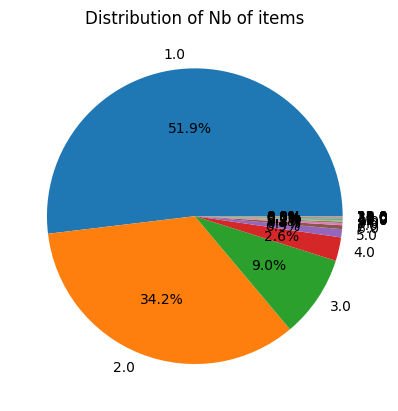

In [250]:
# Plot distribution of Nb_of_items in df in a pie chart
import matplotlib.pyplot as plt
plt.pie(df['Nb_of_items'].value_counts(), labels=df['Nb_of_items'].value_counts().index, autopct='%1.1f%%')
plt.title('Distribution of Nb of items')
plt.show()

##### Distribution of fraud flag in the dataset

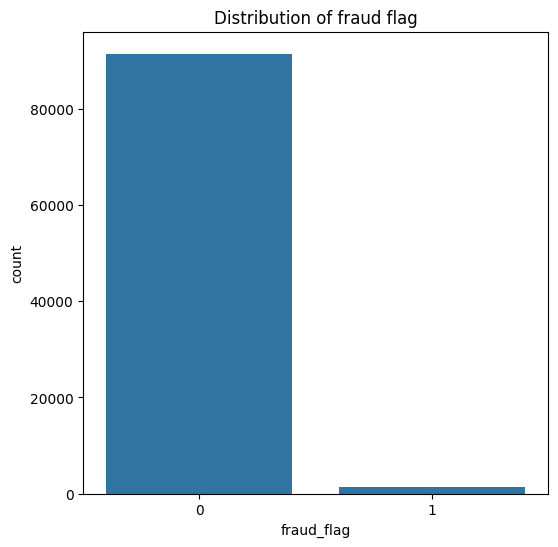

In [251]:
# Plot distribution of fraud_flag in df
plt.figure(figsize=(6, 6))
sns.countplot(x='fraud_flag', data=df)
plt.title('Distribution of fraud flag')
plt.show()

In [252]:
## retrieve proportion of fraud_flag in value_counts with percentage
df.fraud_flag.value_counts(normalize=True)

fraud_flag
0    0.985779
1    0.014221
Name: proportion, dtype: float64

#### Imbalanced dataset, so we will need an unersampling to run the model

##### Distribution of Nb of items by fraud flag

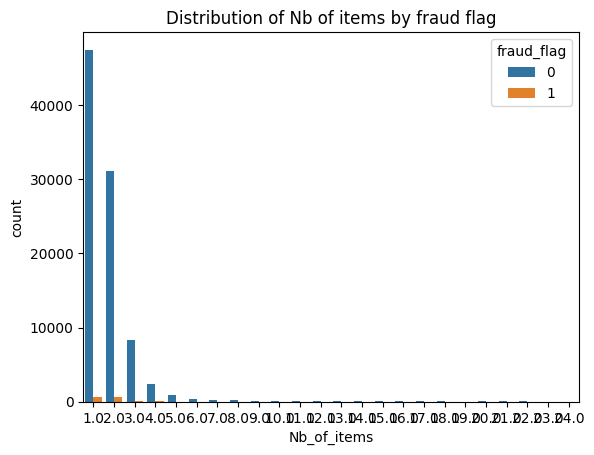

In [253]:
# Plot distribution of Nb_of_items by fraud_flag in df in a sns bar chart
import seaborn as sns
sns.countplot(x='Nb_of_items', hue='fraud_flag', data=df)
plt.title('Distribution of Nb of items by fraud flag')
plt.show()

#### I will keep baskets of maximum 2 items because most of baskets cointain 1 to 2 items and almost all frauds are in these baskets, it will be easier for my limited resources.Indeed, my feature engieneering will categorize each type of items and makers as columns for a total of 440 columns. After undersampling and train test split, keeping all possibilities of Nb of items would enable my model to be relevant(too many columns for rows).

##### Delete rows and columns to keep only 2 items maximum per customer basket

In [254]:
## Delete all rows where Nb_of_items > 3
df = df[df['Nb_of_items'] <= 2]

In [255]:
# Filter out columns with labels ending with numbers greater than or equal to 3
import re
# List of columns to drop
columns_to_drop = []

# Loop through the columns and identify those to drop
for column in df.columns:
    if re.search(r'\d$', column):
        # Extract the numeric part of the column label
        numeric_part = int(re.search(r'(\d+)$', column).group(1))
        # Check if the numeric part is greater than 2
        if numeric_part >= 3:
            columns_to_drop.append(column)

In [256]:
# Drop the identified columns
df = df.drop(columns=columns_to_drop, axis=1)

In [257]:
# Retrieve new shape of df
df.shape

(79889, 14)

##### Now df dataframe has 79889 baskets of maximum 2 items

##### Columns kept

In [258]:
df.columns

Index(['item1', 'item2', 'cash_price1', 'cash_price2', 'make1', 'make2',
       'model1', 'model2', 'goods_code1', 'goods_code2',
       'Nbr_of_prod_purchas1', 'Nbr_of_prod_purchas2', 'Nb_of_items',
       'fraud_flag'],
      dtype='object')

##### Distribution of 10 most popular features values

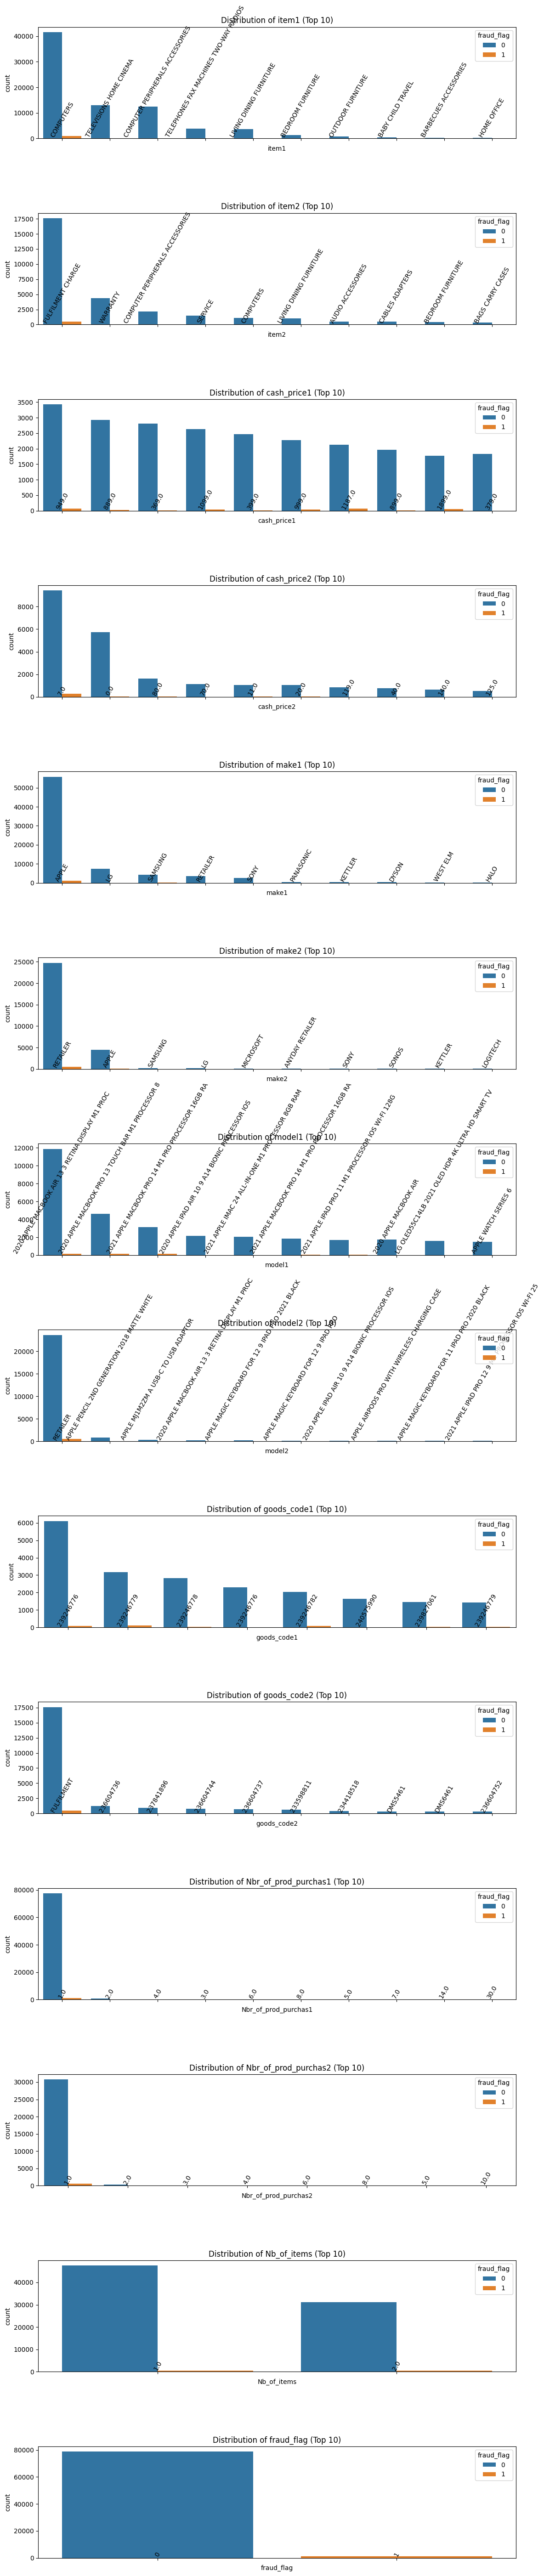

In [259]:
#### Retrieve distribution of features in df with 10 most popular

# List of features for which you want to plot distributions
features_to_plot = df.columns

# Set up subplots
num_plots = len(features_to_plot)
fig, axes = plt.subplots(num_plots, 1, figsize=(12, 4 * num_plots))

# Loop through features and create count plots
for i, feature in enumerate(features_to_plot):
    sns.countplot(x=feature, hue='fraud_flag', data=df, order=df[feature].value_counts().index[:10], ax=axes[i])
    axes[i].set_title(f'Distribution of {feature} (Top 10)')
    
    # Remove x-axis labels
    axes[i].set_xticklabels([])

    # Add labels at the bottom of each bar
    for tick, label in zip(axes[i].get_xticks(), df[feature].value_counts().index[:10]):
        axes[i].text(tick, 0, label, ha='center', va='bottom', rotation =60)

# Adjust layout
plt.tight_layout()
plt.show()


#### Results of the plot for distribution of 10 most popular features values
- Item 1 : Multimédia( Computer and its accessorizes, TV, tel)
- Item 2 : Fulfilment charge > online transactions so maybe create a column "online purchase"
- Item 1 cash price : From 369€ to 1 899€
- Item 2 cash price : From 7€ to 140€
- Make 1 : Apple
- Make 2 : Retailer and Apple
- Model 1 : Apple computers and tabs
- Model 2 : Retailer and Apple
- 2 products in total most of the time for fraud
- Goods code 2 : fulfilment charge for fraud
- 1 product for item 1 for fraud
- 1 product for item 2 for fraud
- Item 1 'Computers' item 2 'Fulfilment charge' for fraud

##### Fraud is very present when:
- Apple is the maker
- 2 products in the customer basket
- combinaison of Item 1 'computers' and item 2 'fulfilment charge'
- 889€ <= cash price item 1 <= 1 899€ 
- cash price item 2 very low

##### Distribution of item 2 knowing 10 most popular item 1

In [260]:
df['item1'].value_counts().head(10).index

Index(['COMPUTERS', 'TELEVISIONS HOME CINEMA',
       'COMPUTER PERIPHERALS ACCESSORIES',
       'TELEPHONES FAX MACHINES TWO-WAY RADIOS', 'LIVING DINING FURNITURE',
       'BEDROOM FURNITURE', 'OUTDOOR FURNITURE', 'BABY CHILD TRAVEL',
       'BARBECUES ACCESSORIES', 'HOME OFFICE'],
      dtype='object', name='item1')

In [261]:
# Get the top 10 most popular item1 values
top_item1_values = df['item1'].value_counts().head(10).index

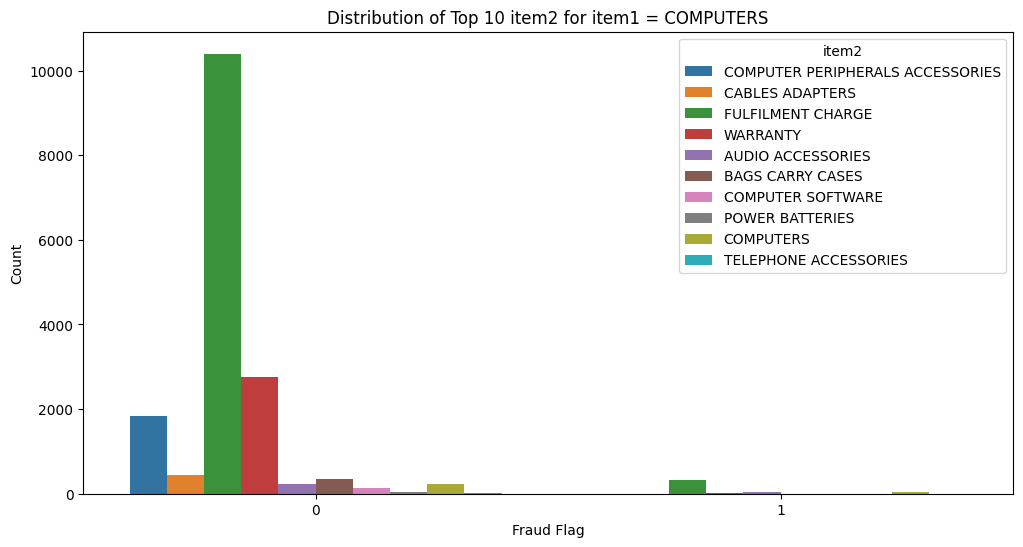

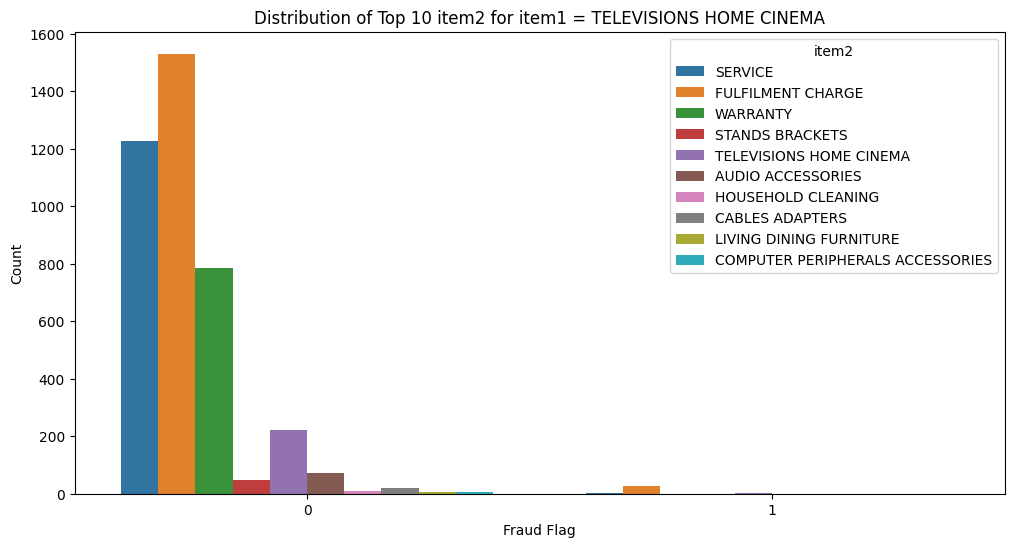

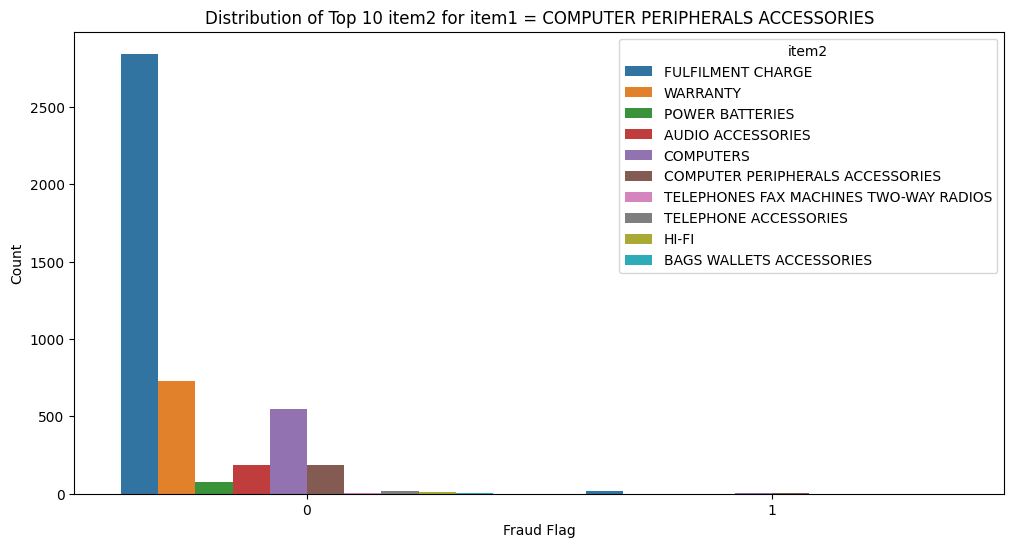

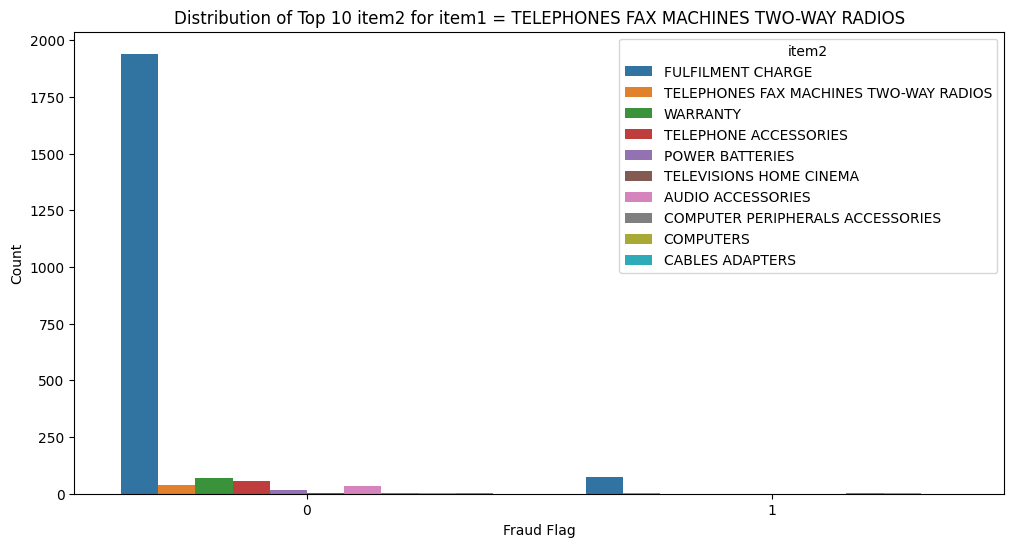

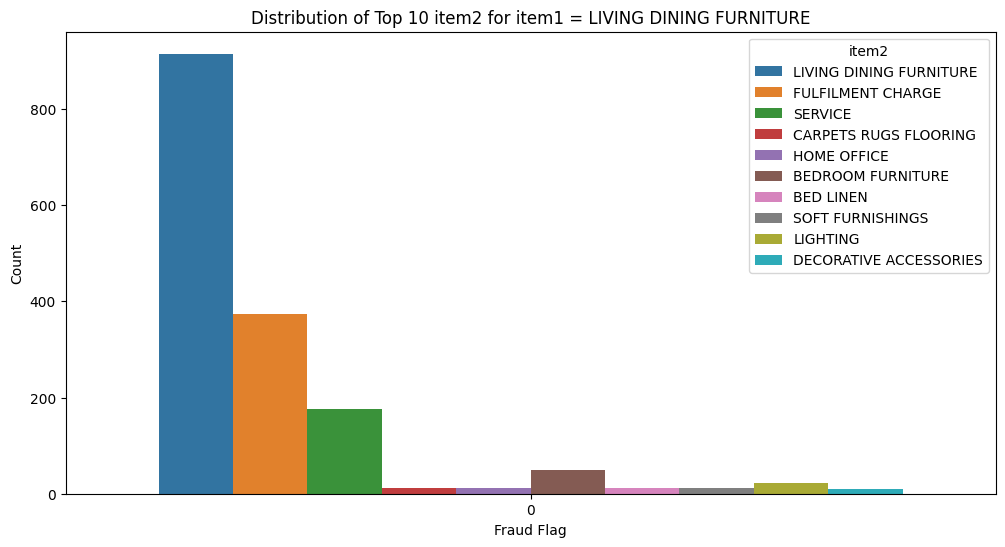

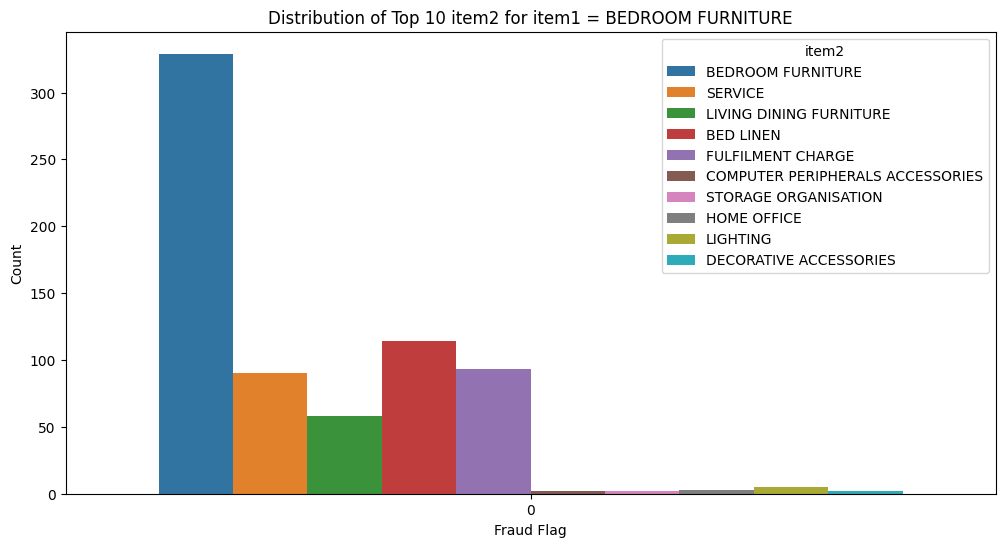

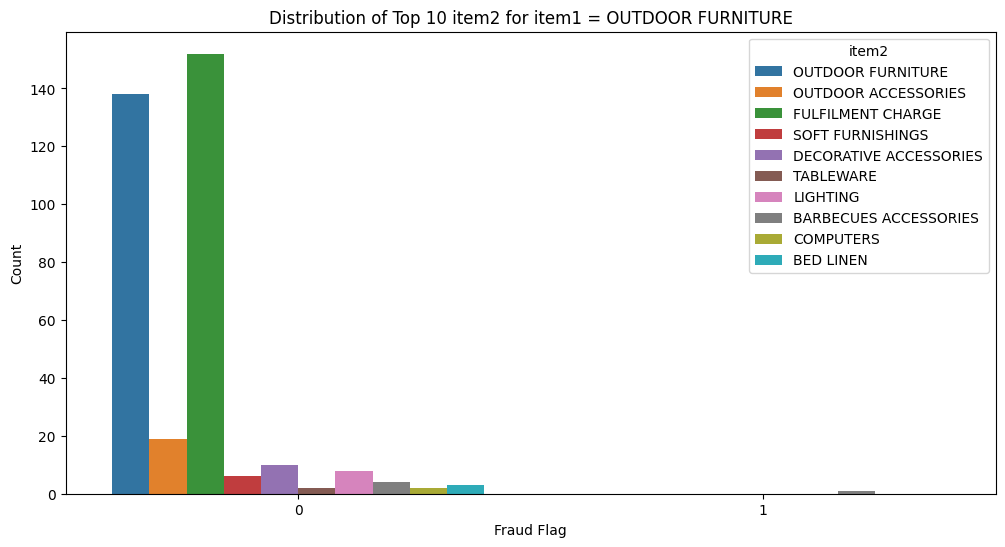

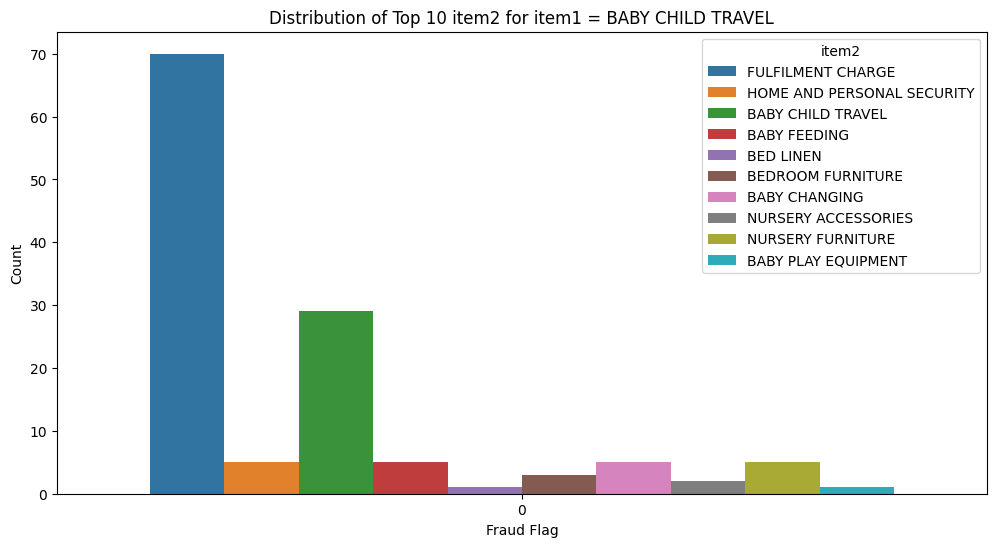

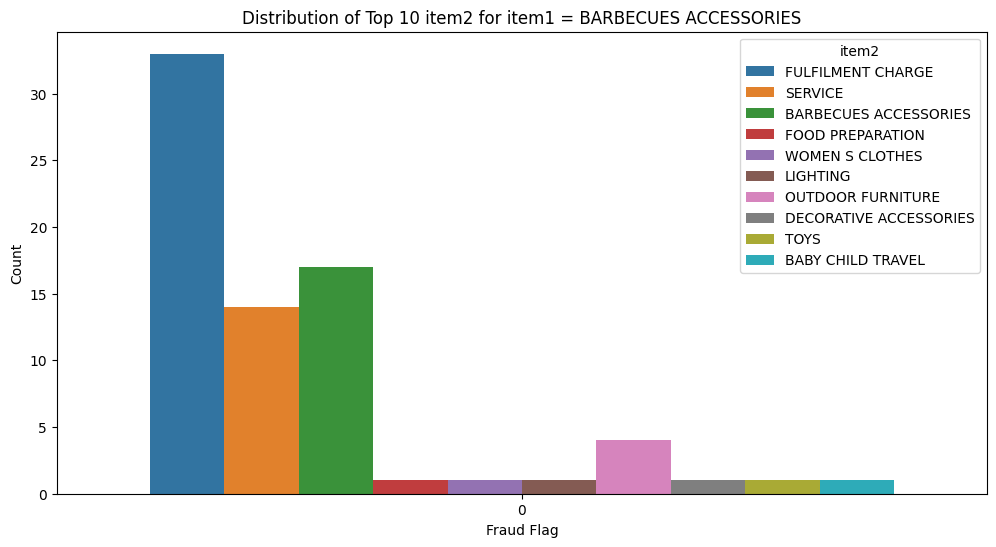

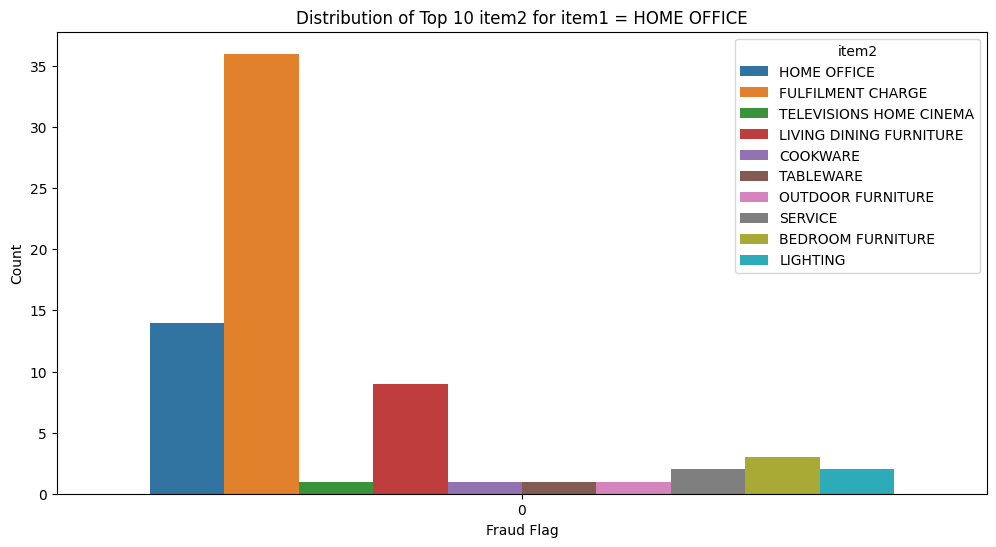

In [262]:
def plot_top_item2_distribution(df, top_item1_values, top_item2_count=10):
    for item1_value in top_item1_values:
        plt.figure(figsize=(12, 6))
        
        subset = df[df['item1'] == item1_value]
        
        # Get the top 10 most popular item2 values
        top_item2_values = subset['item2'].value_counts().head(top_item2_count).index
        
        # Filter the data for the top item2 values
        subset_top_item2 = subset[subset['item2'].isin(top_item2_values)]
        
        # Use seaborn countplot to plot the distribution
        sns.countplot(x='fraud_flag', hue='item2', data=subset_top_item2)
        
        plt.legend(title='item2')
        plt.xlabel('Fraud Flag')
        plt.ylabel('Count')
        plt.title(f'Distribution of Top {top_item2_count} item2 for item1 = {item1_value}')
        plt.show()

# Get the top 10 most popular item1 values
top_item1_values = df['item1'].value_counts().head(10).index

# Call the function
plot_top_item2_distribution(df, top_item1_values, top_item2_count=10)

#### Nothing relevant from these plots because of the imbalance of the datase, let's take a sample of it with same proportion of fraud.

In [263]:
## Retrieve number of all rows where fraud_flag = 1 in df
df[df['fraud_flag'] == 1].shape[0]

1205

In [264]:
## Create a sample df with same proportion of fraud and non-fraud from shuffled df
from sklearn.utils import shuffle
total_rows = 1205*2
fraud_rows = int(total_rows / 2)
non_fraud_rows = total_rows - fraud_rows
df_shuffled = shuffle(df, random_state=42)
fraud_sample = df_shuffled[df_shuffled['fraud_flag'] == 1].sample(n=fraud_rows)
non_fraud_sample = df_shuffled[df_shuffled['fraud_flag'] == 0].sample(n=non_fraud_rows)
balanced_df = pd.concat([fraud_sample, non_fraud_sample])

In [265]:
balanced_df = shuffle(balanced_df, random_state=42)

In [266]:
balanced_df.shape

(2410, 14)

In [267]:
balanced_df.fraud_flag.value_counts()

fraud_flag
0    1205
1    1205
Name: count, dtype: int64

#### Now we have sample balanced dataset

In [268]:
top_item1_values = df['item1'].value_counts().head(10).index
top_item1_values

Index(['COMPUTERS', 'TELEVISIONS HOME CINEMA',
       'COMPUTER PERIPHERALS ACCESSORIES',
       'TELEPHONES FAX MACHINES TWO-WAY RADIOS', 'LIVING DINING FURNITURE',
       'BEDROOM FURNITURE', 'OUTDOOR FURNITURE', 'BABY CHILD TRAVEL',
       'BARBECUES ACCESSORIES', 'HOME OFFICE'],
      dtype='object', name='item1')

In [269]:
# Get the top 10 most popular item1 values in balanced_df
top_item1_values_2 = balanced_df['item1'].value_counts().head(10).index
top_item1_values_2

Index(['COMPUTERS', 'TELEVISIONS HOME CINEMA',
       'COMPUTER PERIPHERALS ACCESSORIES',
       'TELEPHONES FAX MACHINES TWO-WAY RADIOS', 'LIVING DINING FURNITURE',
       'BEDROOM FURNITURE', 'OUTDOOR FURNITURE', 'BABY CHILD TRAVEL',
       'IMAGING EQUIPMENT', 'BARBECUES ACCESSORIES'],
      dtype='object', name='item1')

In [270]:
## Compare top 10 item1 in df and balanced_df
common_values = set(top_item1_values).intersection(top_item1_values_2)

print("Common values:", common_values)
print("Values unique to df:", set(top_item1_values) - set(top_item1_values_2))
print("Values unique to balanced_df:", set(top_item1_values_2) - set(top_item1_values))

Common values: {'TELEVISIONS HOME CINEMA', 'TELEPHONES FAX MACHINES TWO-WAY RADIOS', 'OUTDOOR FURNITURE', 'BARBECUES ACCESSORIES', 'COMPUTERS', 'BABY CHILD TRAVEL', 'COMPUTER PERIPHERALS ACCESSORIES', 'BEDROOM FURNITURE', 'LIVING DINING FURNITURE'}
Values unique to df: {'HOME OFFICE'}
Values unique to balanced_df: {'IMAGING EQUIPMENT'}


##### Almost same top 10 item 1 in original dataset and its balanced sample

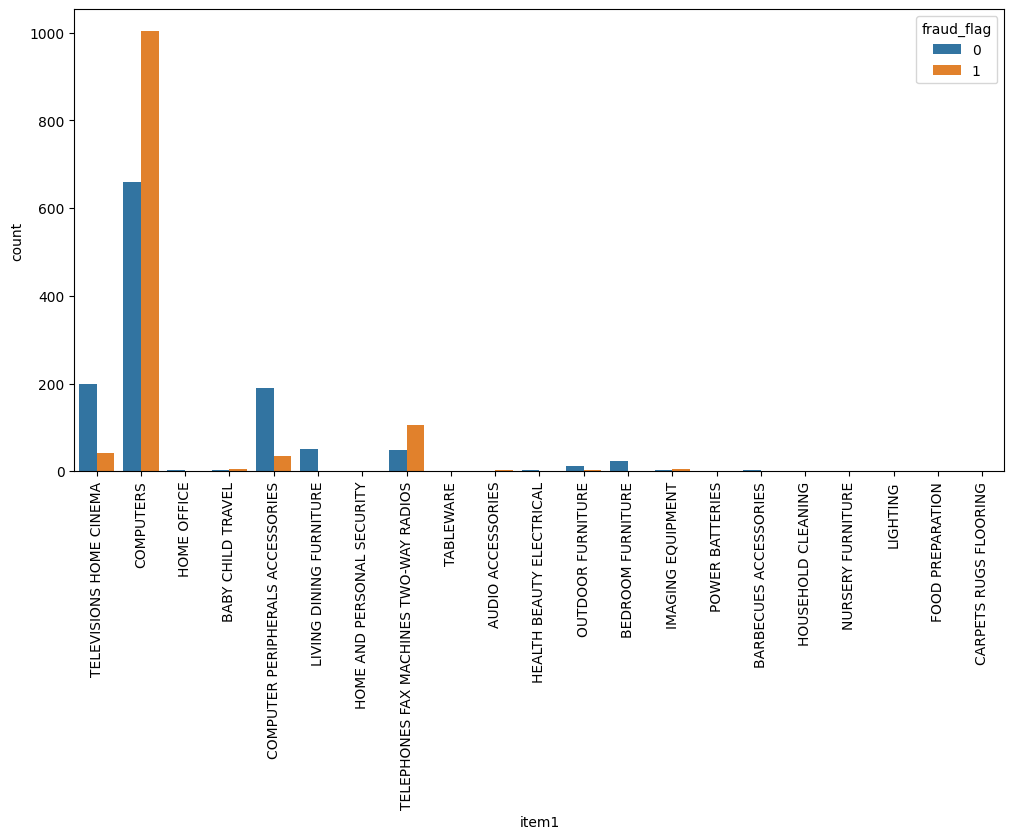

In [271]:
## Retrieve distribution of top 10 item1 by fraud_flag

plt.figure(figsize=(12, 6))
sns.countplot(x='item1', hue='fraud_flag', data=balanced_df)
plt.xticks(rotation=90)
plt.show()

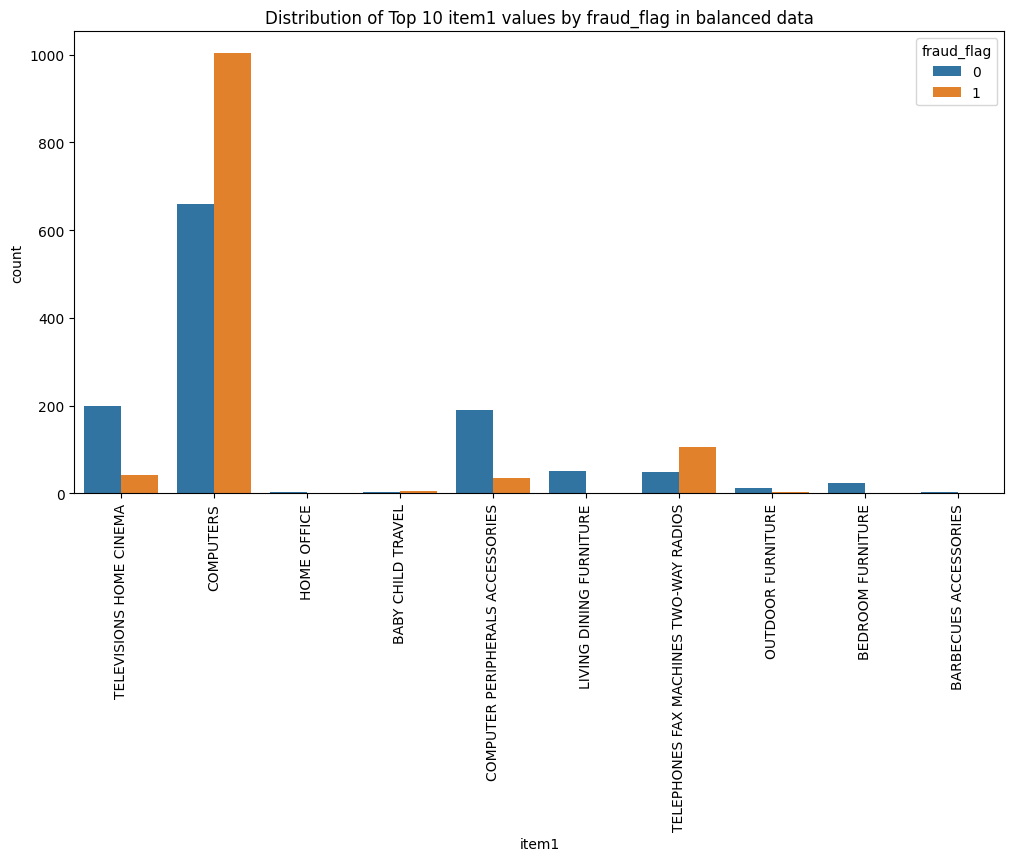

In [272]:
# Filter the dataframe for the top 10 item1 values
top_item1_df = balanced_df[balanced_df['item1'].isin(top_item1_values)]

# Plot the distribution of top 10 item1 values by fraud_flag
plt.figure(figsize=(12, 6))
sns.countplot(x='item1', hue='fraud_flag', data=top_item1_df)
plt.title('Distribution of Top 10 item1 values by fraud_flag in balanced data')
plt.xticks(rotation=90)
plt.show()

In [273]:
# Get the top 10 most popular item2 values in balanced_df
top_item2_values_2 = balanced_df['item2'].value_counts().head(10).index
top_item2_values_2

Index(['FULFILMENT CHARGE', 'COMPUTERS', 'WARRANTY', 'AUDIO ACCESSORIES',
       'COMPUTER PERIPHERALS ACCESSORIES', 'SERVICE', 'CABLES ADAPTERS',
       'LIVING DINING FURNITURE', 'TELEPHONES FAX MACHINES TWO-WAY RADIOS',
       'BEDROOM FURNITURE'],
      dtype='object', name='item2')

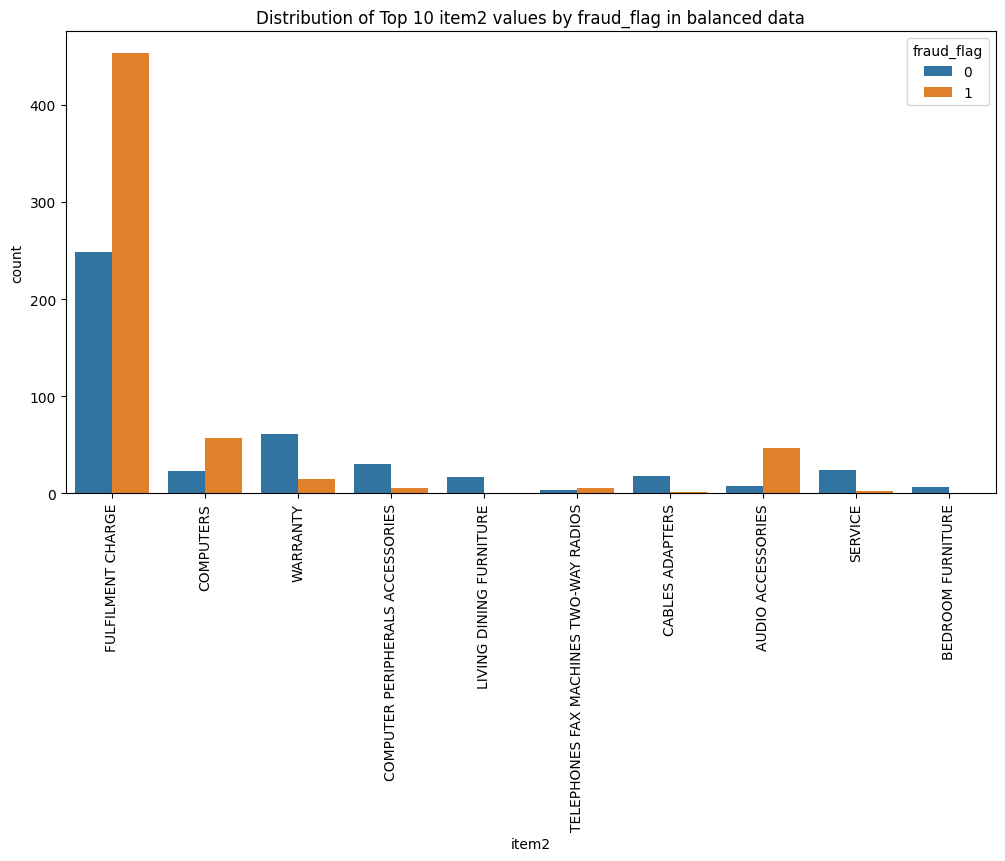

In [274]:
# Filter the dataframe for the top 10 item2 values
top_item2_df = balanced_df[balanced_df['item2'].isin(top_item2_values_2)]

# Plot the distribution of top 10 item2 values by fraud_flag
plt.figure(figsize=(12, 6))
sns.countplot(x='item2', hue='fraud_flag', data=top_item2_df)
plt.title('Distribution of Top 10 item2 values by fraud_flag in balanced data')
plt.xticks(rotation=90)
plt.show()

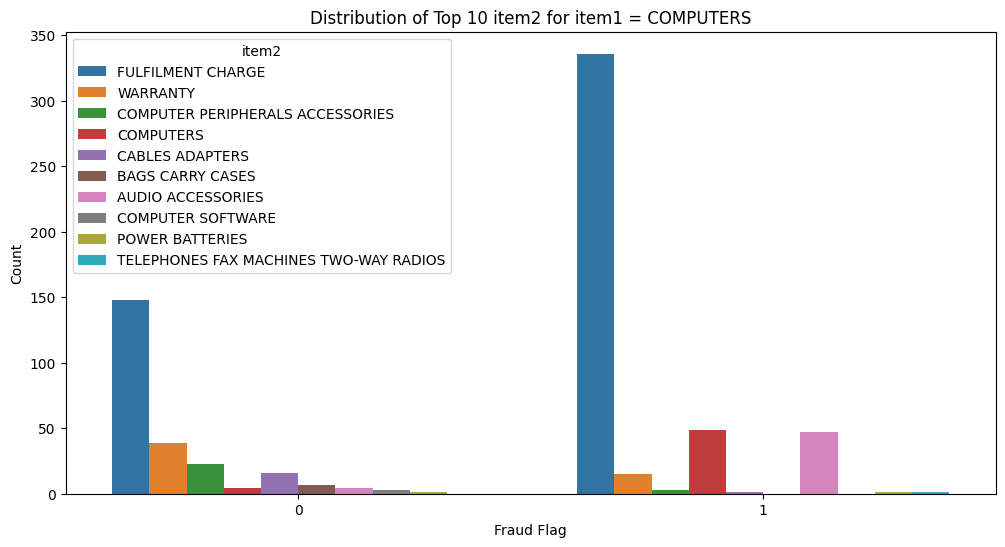

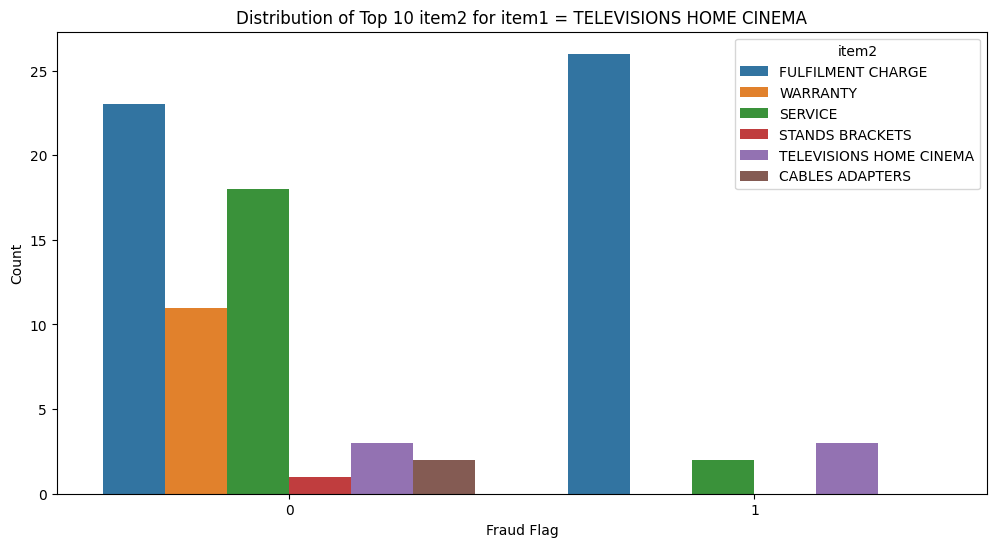

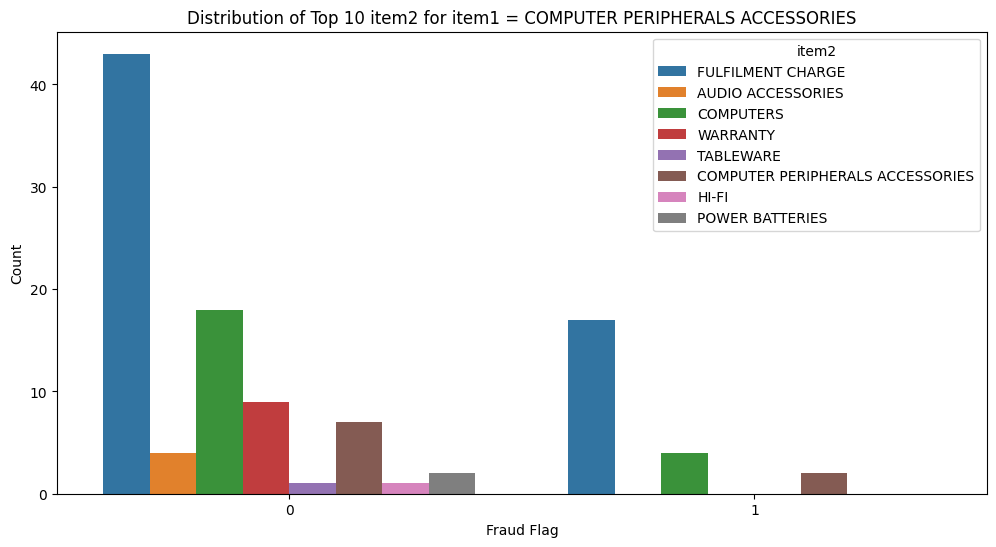

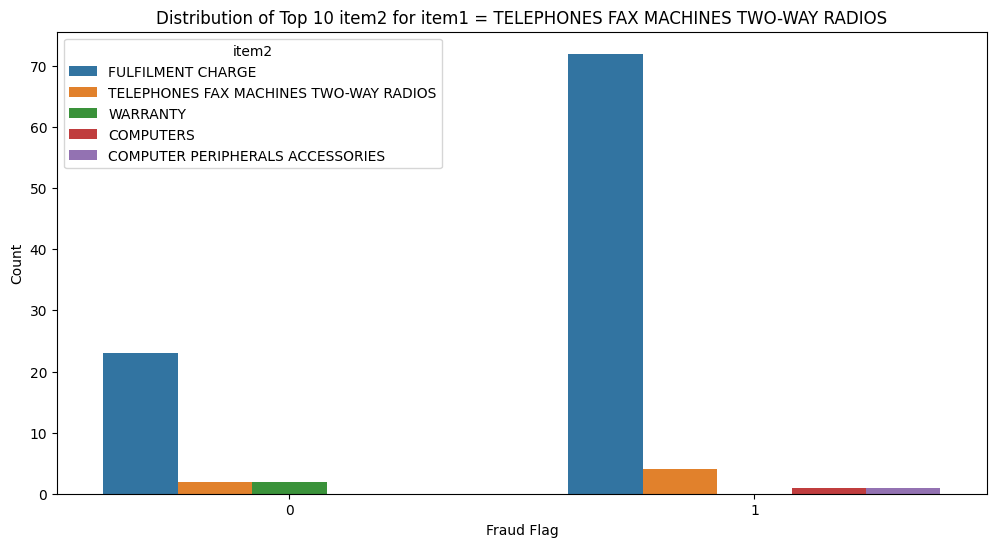

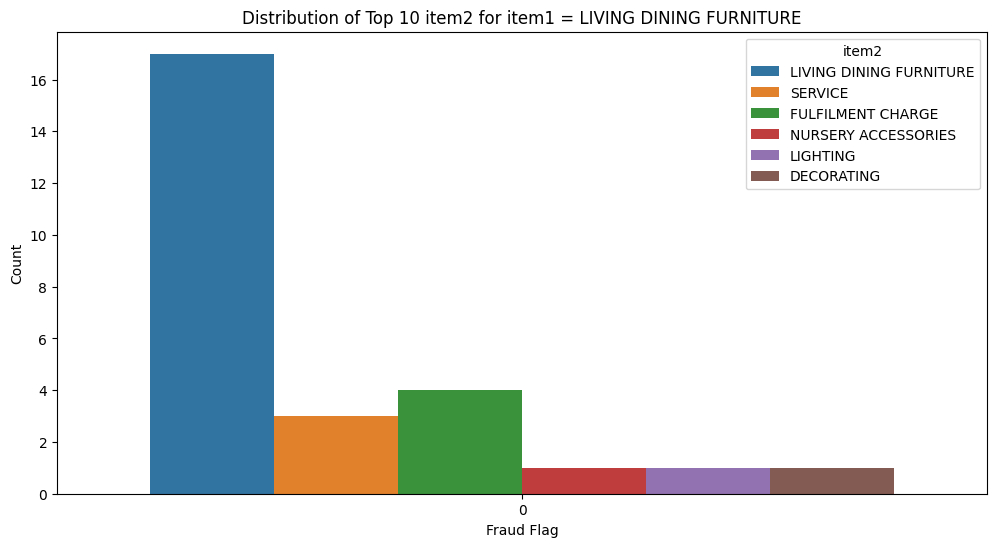

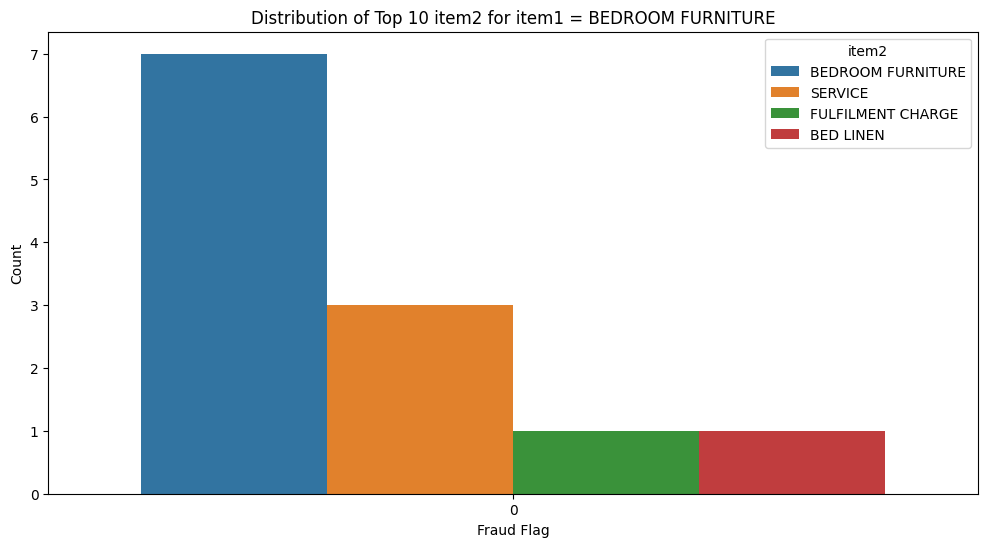

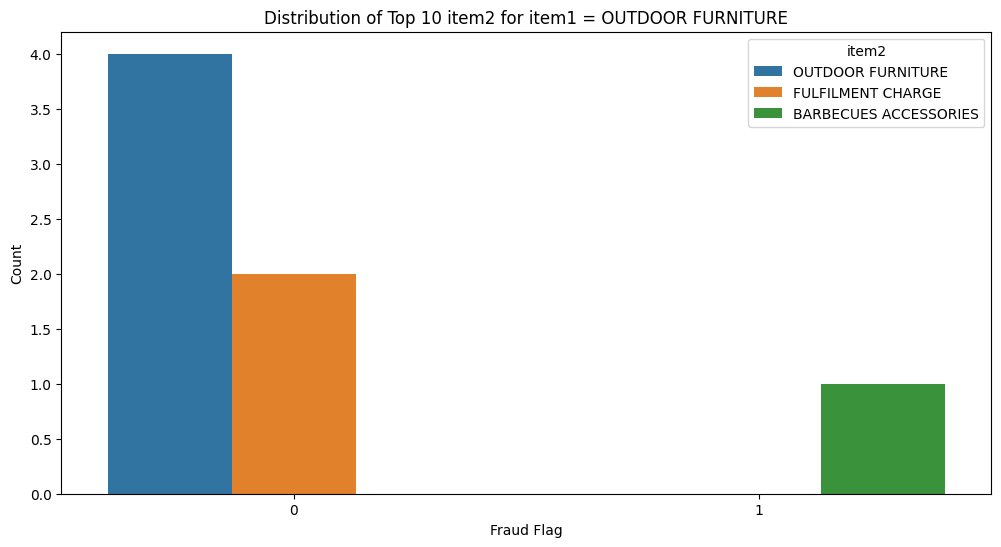

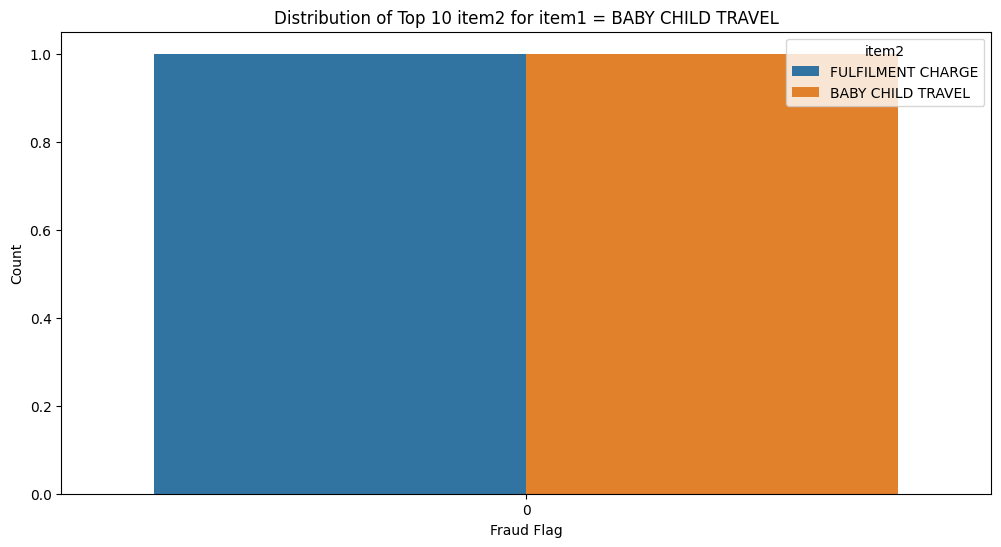

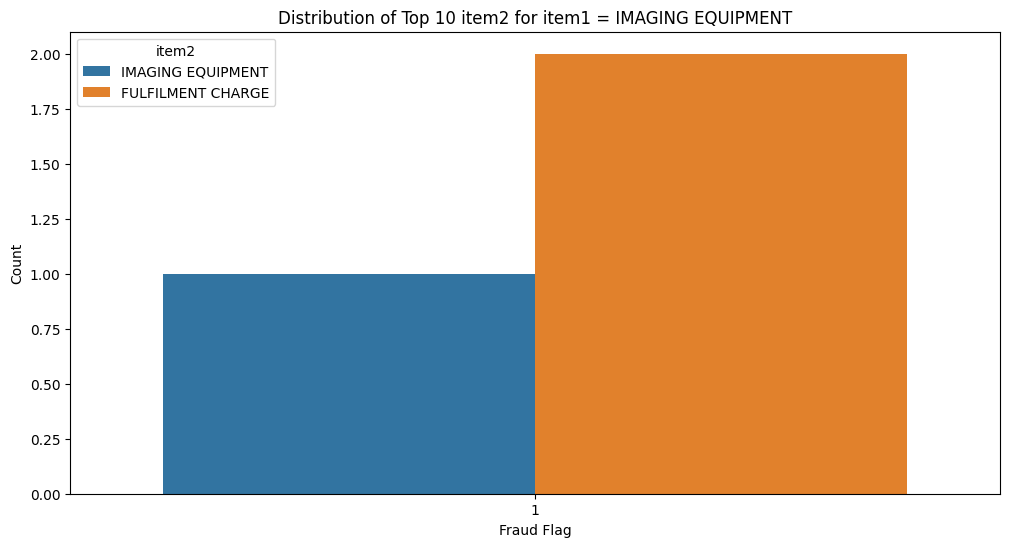

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


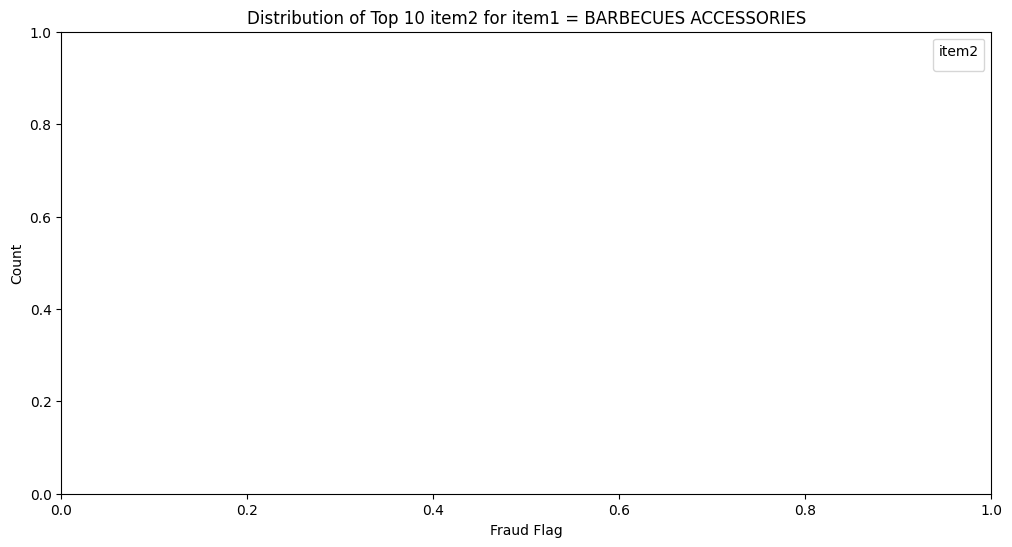

In [275]:
def plot_top_item2_distribution(df, top_item1_values_2, top_item2_count=10):
    for item1_value in top_item1_values_2:
        plt.figure(figsize=(12, 6))
        
        subset = balanced_df[balanced_df['item1'] == item1_value]
        
        # Get the top 10 most popular item2 values
        top_item2_values_2 = subset['item2'].value_counts().head(top_item2_count).index
        
        # Filter the data for the top item2 values
        subset_top_item2 = subset[subset['item2'].isin(top_item2_values_2)]
        
        # Use seaborn countplot to plot the distribution
        sns.countplot(x='fraud_flag', hue='item2', data=subset_top_item2)
        
        plt.legend(title='item2')
        plt.xlabel('Fraud Flag')
        plt.ylabel('Count')
        plt.title(f'Distribution of Top {top_item2_count} item2 for item1 = {item1_value}')
        plt.show()



# Call the function
plot_top_item2_distribution(balanced_df, top_item1_values_2, top_item2_count=10)

#### Almost all frauds here are for items combinaison:
- item 1 Computers with item 2 = Fulfilment charges/computers/audio accessories
- item 1 Television home cinema with item 2 = fulfilment charge/ televison
- item 1 Computer peripherals accessories with same item 2
- item 1 Telephones Fax machine... with fulfilment charge 

#### Proportion of fraud by item1 when item1 is the only item of transaction

## Feature engineering

#### Create column total_cash_price

In [276]:
## Create column total_cash_price
cash_price_columns = ['cash_price' + str(i) for i in range(1, 3)]
df['total_cash_price'] = df[cash_price_columns].sum(axis=1)

In [277]:
df.head(10)

,item1,item2,cash_price1,cash_price2,make1,make2,model1,model2,goods_code1,goods_code2,Nbr_of_prod_purchas1,Nbr_of_prod_purchas2,Nb_of_items,fraud_flag,total_cash_price
ID,,,,,,,,,,,,,,,
85517,COMPUTERS,NaN,889.0,NaN,APPLE,NaN,2020 APPLE MACBOOK AIR 13 3 RETINA DISPLAY M1 ...,NaN,239246776,NaN,1.0,NaN,1.0,0,889.0
51113,COMPUTER PERIPHERALS ACCESSORIES,NaN,409.0,NaN,APPLE,NaN,APPLE WATCH SERIES 6 GPS 44MM SPACE GREY ALUMI...,NaN,239001518,NaN,1.0,NaN,1.0,0,409.0
83008,TELEVISIONS HOME CINEMA,NaN,1399.0,NaN,SAMSUNG,NaN,SAMSUNG QE75Q70A 2021 QLED HDR 4K ULTRA HD SMA...,NaN,239842093,NaN,1.0,NaN,1.0,0,1399.0
78712,COMPUTERS,COMPUTER PERIPHERALS ACCESSORIES,689.0,119.0,APPLE,APPLE,2020 APPLE IPAD AIR 10 9 A14 BIONIC PROCESSOR IOS,APPLE PENCIL 2ND GENERATION 2018 MATTE WHITE,239001422,237841896,1.0,1.0,2.0,0,808.0
77846,TELEVISIONS HOME CINEMA,NaN,1199.0,NaN,SONY,NaN,SONY BRAVIA KE48A9 2020 OLED HDR 4K ULTRA HD S...,NaN,239952954,NaN,1.0,NaN,1.0,0,1199.0
86994,COMPUTER PERIPHERALS ACCESSORIES,NaN,369.0,NaN,APPLE,NaN,APPLE WATCH NIKE SERIES 7 GPS 41MM STARLIGHT A...,NaN,240382074,NaN,1.0,NaN,1.0,0,369.0
113204,TELEVISIONS HOME CINEMA,SERVICE,1299.0,125.0,SONY,RETAILER,SONY BRAVIA XR XR75X90J 2021 LED HDR 4K ULTRA ...,RETAILER,239903730,DMS5461,1.0,1.0,2.0,0,1424.0
41798,COMPUTERS,NaN,1187.0,NaN,APPLE,NaN,2020 APPLE MACBOOK PRO 13 TOUCH BAR M1 PROCESS...,NaN,239246780,NaN,1.0,NaN,1.0,0,1187.0
83365,COMPUTERS,NaN,1899.0,NaN,APPLE,NaN,2021 APPLE MACBOOK PRO 14 M1 PRO PROCESSOR 16G...,NaN,240575996,NaN,1.0,NaN,1.0,0,1899.0


In [278]:
df.groupby('fraud_flag')['total_cash_price'].sum()

fraud_flag
0    92300042.0
1     1801456.0
Name: total_cash_price, dtype: float64

In [279]:
## Create column total_cash_price

cash_price_columns = ['cash_price' + str(i) for i in range(1, 3)]
balanced_df['total_cash_price'] = balanced_df[cash_price_columns].sum(axis=1)

In [280]:
balanced_df['total_cash_price'].head(5)

ID
56805     1119.0
110665     887.0
36009     1194.0
108469    1319.0
90184     2255.0
Name: total_cash_price, dtype: float64

In [281]:
balanced_df.groupby('fraud_flag')['total_cash_price'].sum()

fraud_flag
0    1404716.0
1    1801456.0
Name: total_cash_price, dtype: float64

##### Total cash price is higher for fraud in balanced_df

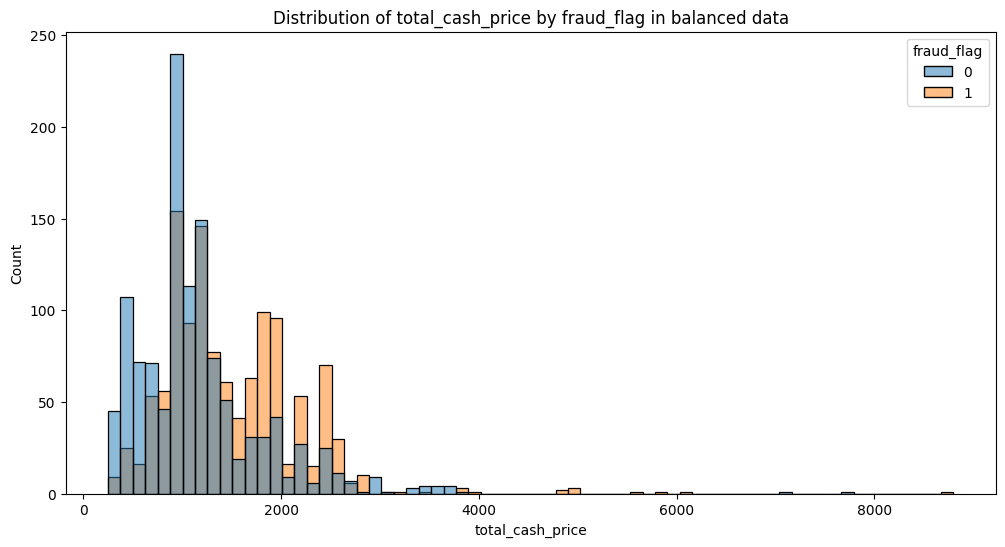

In [282]:
# Plot the distribution of 1000 <= total_cash_price <= 3000  by fraud_flag in df
#df_t = balanced_df[(balanced_df['total_cash_price'] >= 4500) & (balanced_df['total_cash_price'] <= 6500)]
plt.figure(figsize=(12, 6))
sns.histplot(x='total_cash_price', hue='fraud_flag', data=balanced_df)
plt.title('Distribution of total_cash_price by fraud_flag in balanced data')
plt.show()

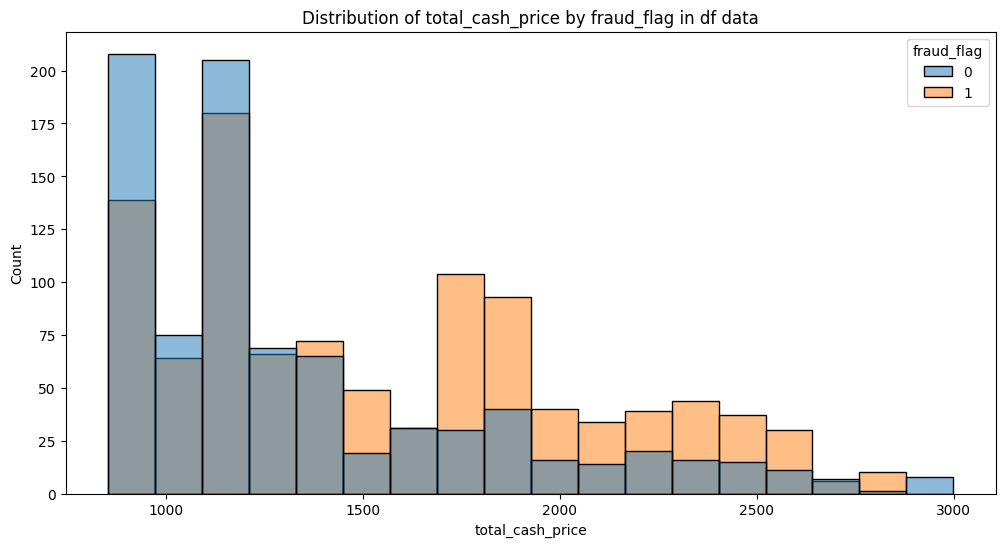

In [283]:
# Plot the distribution of 1000 <= total_cash_price <= 3000  by fraud_flag in balanced_df
df_p = balanced_df[(balanced_df['total_cash_price'] >= 850) & (balanced_df['total_cash_price'] <= 3000)]
plt.figure(figsize=(12, 6))
sns.histplot(x='total_cash_price', hue='fraud_flag', data=df_p)
plt.title('Distribution of total_cash_price by fraud_flag in df data')
plt.show()

In [284]:
single_item_df = balanced_df[balanced_df['Nb_of_items'] == 1]

In [285]:
single_item_df.head(5)

,item1,item2,cash_price1,cash_price2,make1,make2,model1,model2,goods_code1,goods_code2,Nbr_of_prod_purchas1,Nbr_of_prod_purchas2,Nb_of_items,fraud_flag,total_cash_price
ID,,,,,,,,,,,,,,,
110665,COMPUTERS,NaN,887.0,NaN,APPLE,NaN,2020 APPLE MACBOOK AIR 13 3 RETINA DISPLAY M1 ...,NaN,239246776,NaN,1.0,NaN,1.0,0,887.0
108469,COMPUTERS,NaN,1319.0,NaN,APPLE,NaN,2020 APPLE MACBOOK PRO 13 TOUCH BAR M1 PROCESS...,NaN,239246783,NaN,1.0,NaN,1.0,0,1319.0
90184,COMPUTERS,NaN,2255.0,NaN,APPLE,NaN,2021 APPLE MACBOOK PRO 14 M1 PRO PROCESSOR 16G...,NaN,240575992,NaN,1.0,NaN,1.0,1,2255.0
62209,COMPUTERS,NaN,489.0,NaN,SAMSUNG,NaN,SAMSUNG GALAXY TAB S7 FE TABLET WITH BLUETOOTH...,NaN,240087889,NaN,1.0,NaN,1.0,0,489.0
112271,COMPUTERS,NaN,719.0,NaN,APPLE,NaN,2022 APPLE IPAD AIR 10 9 M1 PROCESSOR IPADOS W...,NaN,241018007,NaN,1.0,NaN,1.0,0,719.0


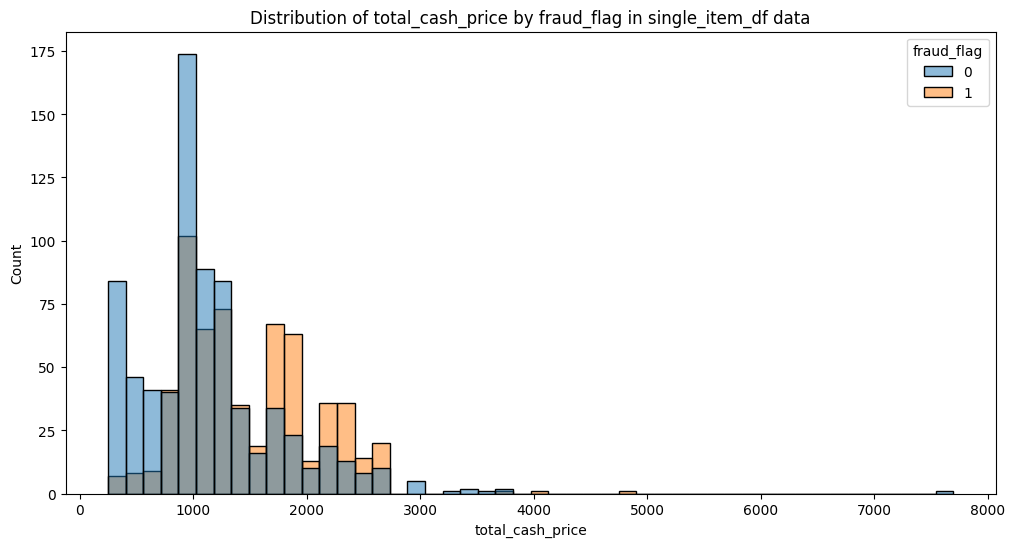

In [286]:
plt.figure(figsize=(12, 6))
sns.histplot(x='total_cash_price', hue='fraud_flag', data=single_item_df)
plt.title('Distribution of total_cash_price by fraud_flag in single_item_df data')
plt.show()

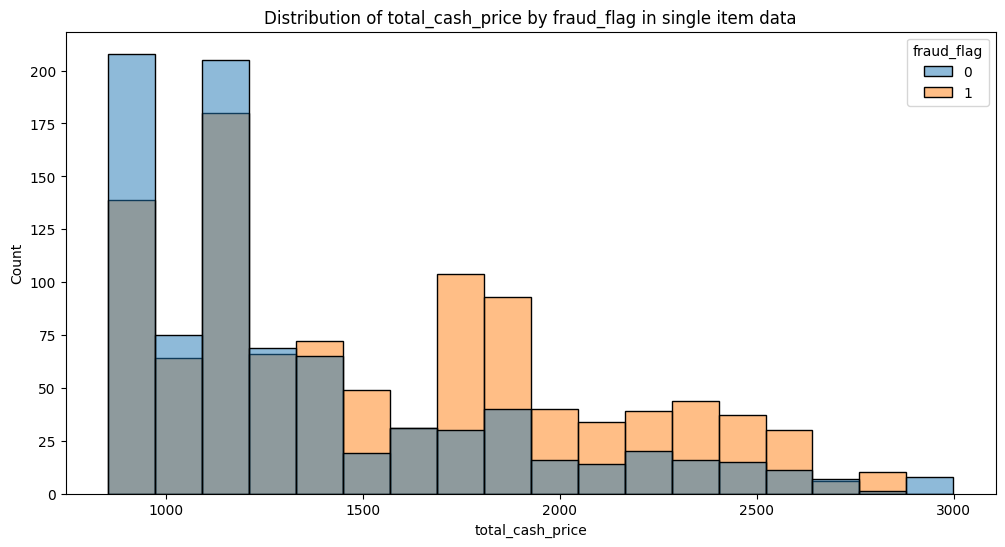

In [287]:
# Plot the distribution of 1000 <= total_cash_price <= 3000  by fraud_flag in single_item_df
df_si = single_item_df[(single_item_df['total_cash_price'] >= 1500) & (single_item_df['total_cash_price'] <= 2700)]
plt.figure(figsize=(12, 6))
sns.histplot(x='total_cash_price', hue='fraud_flag', data=df_p)
plt.title('Distribution of total_cash_price by fraud_flag in single item data')
plt.show()

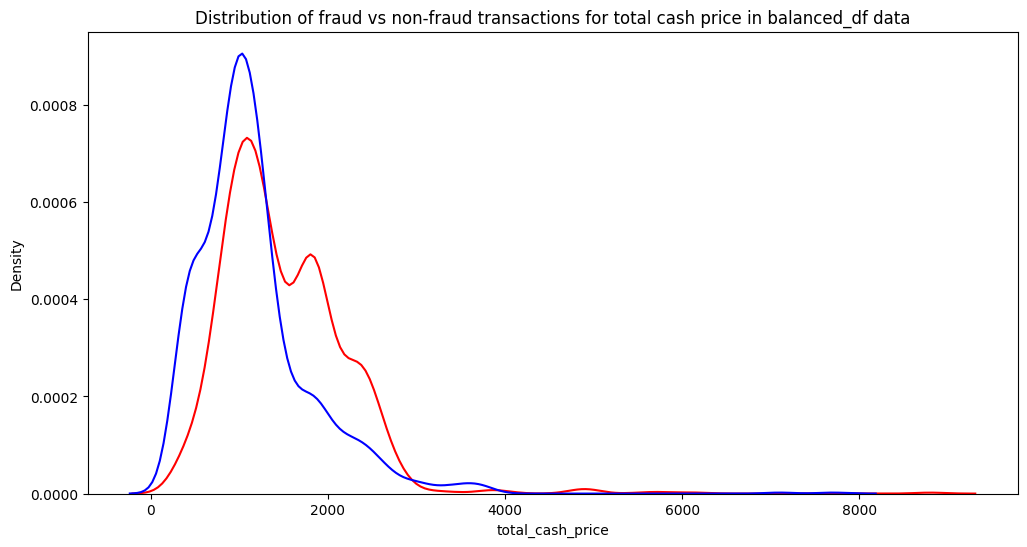

In [288]:
plt.figure(figsize=(12, 6))

ax0 = sns.kdeplot(balanced_df[(balanced_df["fraud_flag"] == 1)]["total_cash_price"], c='red', label="Fraud")
ax1 = sns.kdeplot(balanced_df[(balanced_df["fraud_flag"] == 0)]["total_cash_price"], c='blue', label="Non-fraud")

plt.title("Distribution of fraud vs non-fraud transactions for total cash price in balanced_df data")
plt.show()

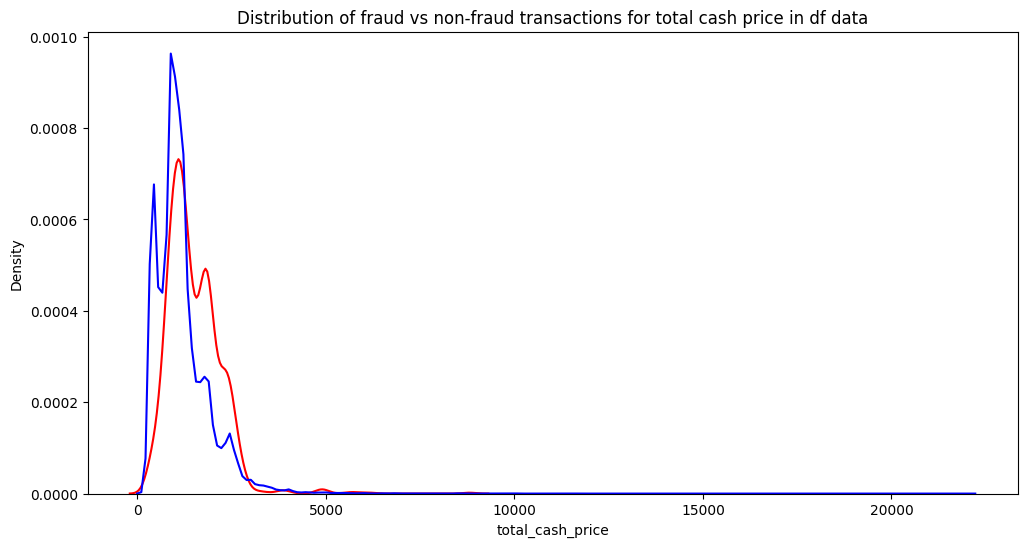

In [289]:
plt.figure(figsize=(12, 6))

ax0 = sns.kdeplot(df[(df["fraud_flag"] == 1)]["total_cash_price"], c='red', label="Fraud")
ax1 = sns.kdeplot(df[(df["fraud_flag"] == 0)]["total_cash_price"], c='blue', label="Non-fraud")

plt.title("Distribution of fraud vs non-fraud transactions for total cash price in df data")
plt.show()

In [290]:
nb_of_prod_columns = ['Nbr_of_prod_purchas' + str(i) for i in range(1, 3)]

In [291]:
## Create function to compute total_Nbr_of_prod_purchas
def compute_totals(df):
    df['total_Nbr_of_prod_purchas'] = df[nb_of_prod_columns].sum(axis=1)
    return df

In [292]:
df = compute_totals(df)

In [297]:
balanced_df = compute_totals(balanced_df)

In [293]:
df.head(10)

,item1,item2,cash_price1,cash_price2,make1,make2,model1,model2,goods_code1,goods_code2,Nbr_of_prod_purchas1,Nbr_of_prod_purchas2,Nb_of_items,fraud_flag,total_cash_price,total_Nbr_of_prod_purchas
ID,,,,,,,,,,,,,,,,
85517,COMPUTERS,NaN,889.0,NaN,APPLE,NaN,2020 APPLE MACBOOK AIR 13 3 RETINA DISPLAY M1 ...,NaN,239246776,NaN,1.0,NaN,1.0,0,889.0,1.0
51113,COMPUTER PERIPHERALS ACCESSORIES,NaN,409.0,NaN,APPLE,NaN,APPLE WATCH SERIES 6 GPS 44MM SPACE GREY ALUMI...,NaN,239001518,NaN,1.0,NaN,1.0,0,409.0,1.0
83008,TELEVISIONS HOME CINEMA,NaN,1399.0,NaN,SAMSUNG,NaN,SAMSUNG QE75Q70A 2021 QLED HDR 4K ULTRA HD SMA...,NaN,239842093,NaN,1.0,NaN,1.0,0,1399.0,1.0
78712,COMPUTERS,COMPUTER PERIPHERALS ACCESSORIES,689.0,119.0,APPLE,APPLE,2020 APPLE IPAD AIR 10 9 A14 BIONIC PROCESSOR IOS,APPLE PENCIL 2ND GENERATION 2018 MATTE WHITE,239001422,237841896,1.0,1.0,2.0,0,808.0,2.0
77846,TELEVISIONS HOME CINEMA,NaN,1199.0,NaN,SONY,NaN,SONY BRAVIA KE48A9 2020 OLED HDR 4K ULTRA HD S...,NaN,239952954,NaN,1.0,NaN,1.0,0,1199.0,1.0
86994,COMPUTER PERIPHERALS ACCESSORIES,NaN,369.0,NaN,APPLE,NaN,APPLE WATCH NIKE SERIES 7 GPS 41MM STARLIGHT A...,NaN,240382074,NaN,1.0,NaN,1.0,0,369.0,1.0
113204,TELEVISIONS HOME CINEMA,SERVICE,1299.0,125.0,SONY,RETAILER,SONY BRAVIA XR XR75X90J 2021 LED HDR 4K ULTRA ...,RETAILER,239903730,DMS5461,1.0,1.0,2.0,0,1424.0,2.0
41798,COMPUTERS,NaN,1187.0,NaN,APPLE,NaN,2020 APPLE MACBOOK PRO 13 TOUCH BAR M1 PROCESS...,NaN,239246780,NaN,1.0,NaN,1.0,0,1187.0,1.0
83365,COMPUTERS,NaN,1899.0,NaN,APPLE,NaN,2021 APPLE MACBOOK PRO 14 M1 PRO PROCESSOR 16G...,NaN,240575996,NaN,1.0,NaN,1.0,0,1899.0,1.0


In [294]:
## Create function to compute the mean(average) of cash_price per product purchased

def compute_ratios(df):
    df['mean_product_cash_price'] = df['total_cash_price'] / df['total_Nbr_of_prod_purchas']

    return df

In [295]:
## Apply the function to df and balanced_df
df = compute_ratios(df)

In [298]:
## Apply the function to balanced_df
balanced_df = compute_ratios(balanced_df)

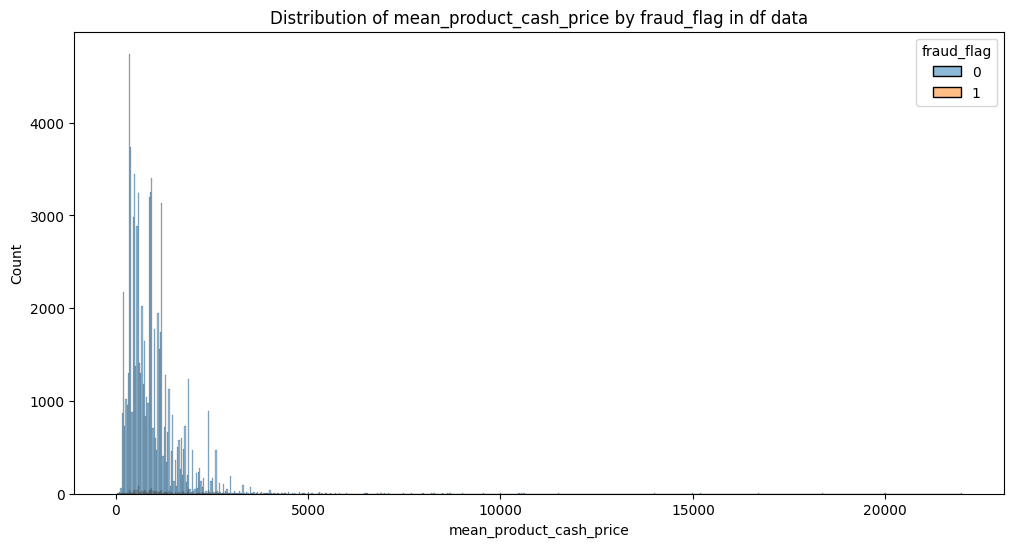

In [296]:
## Distribution of mean_product_cash_price by fraud_flag in df
plt.figure(figsize=(12, 6))
sns.histplot(x='mean_product_cash_price', hue='fraud_flag', data=df)
plt.title('Distribution of mean_product_cash_price by fraud_flag in df data')
plt.show()

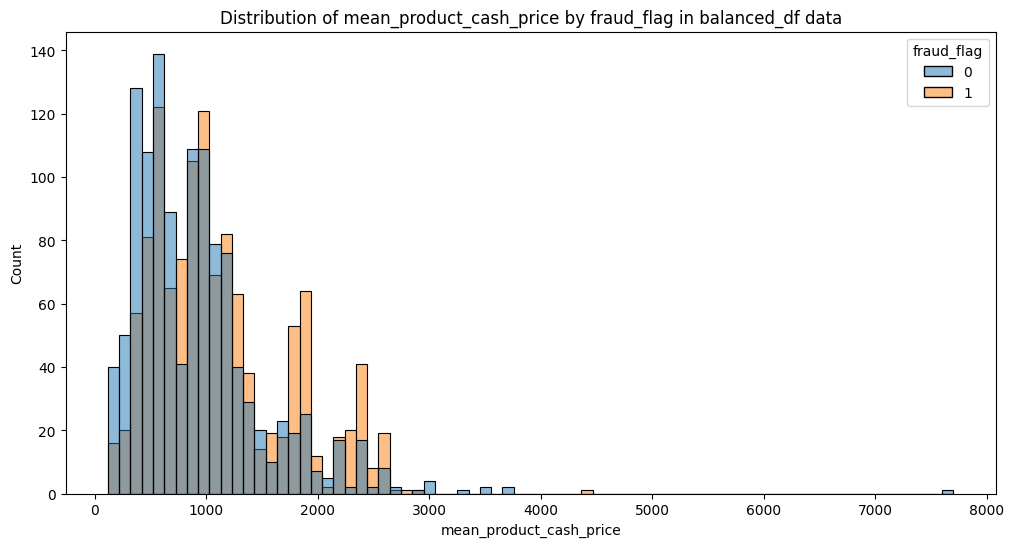

In [299]:
## Distribution of mean_product_cash_price by fraud_flag in balanced_df
plt.figure(figsize=(12, 6))
sns.histplot(x='mean_product_cash_price', hue='fraud_flag', data=balanced_df)
plt.title('Distribution of mean_product_cash_price by fraud_flag in balanced_df data')
plt.show()

#### We highlighted fraud through combinaison of items and total cash price. 

### To translate these insights into a model, as I mentioned earlier, I opted to create a column for each item and maker. I excluded goods_code and models from consideration due to resource constraints that I currently lack for running my model.